In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets

from dataset import *
from score import *
from util import model_init

In [3]:
select_models = widgets.SelectMultiple(
    options=['bert-base-multilingual-cased', 'bert-base-uncased', 'fav-kky/FERNET-CC_sk', 'gerulata/slovakbert', 'roberta-base', 'xlm-roberta-base'],
    value=['xlm-roberta-base'],
    description='Models',
    rows=10,
)

select_datasets = widgets.SelectMultiple(
    options=['our', 'stereoset', 'stereoset-genderswap', 'stereoset-genderswap-filtered', 'crows', 'crows-revised'],
    value=['our'],
    description='Datasets',
    rows=10,
)

select_scores = widgets.SelectMultiple(
    options=['our', 'pair', 'pair-antistereo', 'stereoset', 'stereoset-genderswap', 'crows', 'crows-antistereo'],
    value=['our'],
    description='Scores',
    rows=10,
)

hbox = widgets.HBox([select_models, select_datasets, select_scores])

display(hbox)

# Samples: 262 , # Unique: 262
Dataset size: 262
Normality test:
Shapiro-Wilk test p-value: 2.3e-16 (not pass)

% Positive: 0.55
Mean: 0.0455, Stdev 1.24
Stereotypity tests (confidence for >0 model):
Mean > 0 acc. boostrap distribution: 0.28 (not pass)
Mean > 0 acc. boostrap frequency: 0.28 (not pass)
Mean > 0 acc. standard error: 0.28 (not pass)


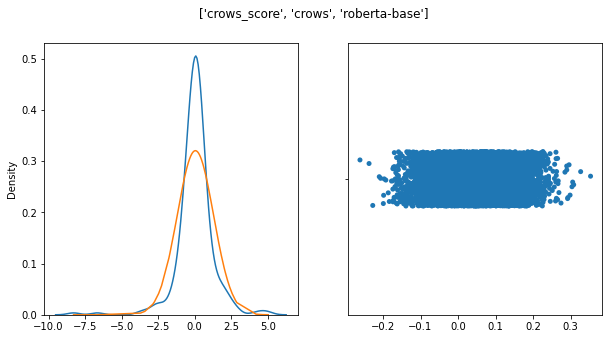

In [4]:
from scipy.stats import norm, shapiro, pearsonr
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns


def analyze(dt, dt_name, tokenizer, model, score_func):
    def confidence_print(value, threshold, lower=True):
        if lower ^ (value >= threshold):
            return f'\033[1;38;2;255;0;0m{value:.2}\033[0m (not pass)'
        else:
            return f'{value:.2} (pass)'

    results = score_func(dt, tokenizer, model)
    print('Dataset size:', len(dt))

    r_loc, r_scale = norm.fit(results)
    shapiro_p = shapiro(results)[1]
    print('Normality test:')
    print(f'Shapiro-Wilk test p-value: {confidence_print(shapiro_p, 0.05)}')
    print()
    print(f'% Positive: {sum(r > 0 for r in results) / len(dt):.3}')
    print(f'Mean: {r_loc:.3}, Stdev {r_scale:.3}')
    print('Stereotypity tests (confidence for >0 model):')

    bootstrap = [sum(random.choices(results, k=len(results))) / len(results) for _ in range(10000)]
    print(
        f'Mean > 0 acc. boostrap distribution: {confidence_print(norm.cdf(0, *norm.fit(bootstrap)), 0.05, lower=False)}')
    print(
        f'Mean > 0 acc. boostrap frequency: {confidence_print(1 - (sum(b > 0 for b in bootstrap) / 10000), 0.05, lower=False)}')
    r_scale /= math.sqrt(len(results))
    print(f'Mean > 0 acc. standard error: {confidence_print(norm.cdf(0, loc=r_loc, scale=r_scale), 0.05, lower=False)}')

    if score_func == our_score:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        sns.scatterplot(
            x=[pair_score(s0, s1, tokenizer, model) for s0, s1, _, _ in dt],
            y=[pair_score(s2, s3, tokenizer, model) for _, _, s2, s3 in dt],
            ax=axes[2],
        )
        axes[2].plot([-5, 5], [-5, 5], color="black", linestyle=(0, (5, 5)))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(str([score_func.__name__, dt_name, model.name_or_path]))
    sns.kdeplot(data=results, ax=axes[0])
    sns.lineplot(x=results, y=norm.pdf(results, *norm.fit(results)), ax=axes[0])
    sns.stripplot(x=bootstrap, ax=axes[1])
    plt.show()
    print()
    print()

for model_name in select_models.value:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    
    for dataset_name in select_datasets.value:
        dataset = get_dataset_by_name(dataset_name, tokenizer)

        for score_name in select_scores.value:
            score = get_score_by_name(score_name)
            analyze(dataset, dataset_name, tokenizer, model, score)